In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)




In [2]:
def get_data(data_path):
    '''returns a DataFrame with search tracks'''
    data = pd.read_json(data_path)
    data = pd.DataFrame.from_dict(data['__collections__']["search_track"])
    return data


def preprocess_data(data):
    data = data.T
    data = data.drop(columns = ['user_longitude', 'user_latitude', '__collections__'])
    data.reset_index(level=0, inplace=True)
    data.drop(columns="index")
    data['search_method'] = data['search_method'].convert_dtypes()
    
#     data = data[data.search_method == 'update_time_home']
    
    data.drop(columns='index', inplace=True)
    data['timestamp'] = pd.to_datetime(data['timestamp'], utc=True, errors='coerce')
    data['arrive'] = pd.to_datetime(data['arrive'], utc=True, errors='coerce')
    data['leave'] = pd.to_datetime(data['leave'], utc=True, errors='coerce')
    data['timestamp'] = data.timestamp.dt.strftime("%Y-%m-%d %H:%M:%S")
    data['arrive'] = data.arrive.dt.strftime("%Y-%m-%d %H:%M:%S")
    data['leave'] = data.leave.dt.strftime("%Y-%m-%d %H:%M:%S")
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data['arrive'] = pd.to_datetime(data['arrive'])
    data['leave'] = pd.to_datetime(data['leave'])

    return data

def preproc(data_path):
    data = get_data(data_path)
    return preprocess_data(data)



In [3]:
data = preproc('../raw_data/dataBackup.json')
data.head(2)

,search_longitude,search_latitude,timestamp,leave,arrive,search_method,uid
0,-58.404267,-34.614640,2021-03-28 16:30:39,2021-03-28 17:30:13,2021-03-28 16:30:13,google,unauthenticated
1,-58.419543,-34.575729,2021-02-04 15:56:36,2021-02-04 17:00:36,2021-02-04 16:00:36,startup,unauthenticated


In [4]:
data["search_hour"] = data["timestamp"].dt.hour
data["arrive_hour"] = data["arrive"].dt.hour
data["leave_hour"] = data["leave"].dt.hour



In [5]:
data


,search_longitude,search_latitude,timestamp,leave,arrive,search_method,uid,search_hour,arrive_hour,leave_hour
0,-58.404267,-34.614640,2021-03-28 16:30:39,2021-03-28 17:30:13,2021-03-28 16:30:13,google,unauthenticated,16.0,16,17
1,-58.419543,-34.575729,2021-02-04 15:56:36,2021-02-04 17:00:36,2021-02-04 16:00:36,startup,unauthenticated,15.0,16,17
2,-58.414274,-34.581036,2021-01-12 10:28:04,2021-01-12 11:30:04,2021-01-12 10:30:04,startup,unauthenticated,10.0,10,11
3,-58.433503,-34.577048,2021-02-05 08:19:35,2021-02-05 09:30:35,2021-02-05 08:30:35,startup,unauthenticated,8.0,8,9
4,-58.440447,-34.620694,2021-01-31 22:35:42,2021-02-28 17:32:00,2021-02-28 15:56:00,google,None,22.0,15,17
...,...,...,...,...,...,...,...,...,...,...
21129,-58.507150,-34.575842,2020-09-14 06:35:26,2020-09-14 07:45:26,2020-09-14 06:45:26,startup,unauthenticated,6.0,6,7
21130,-58.383415,-34.591915,2021-01-23 04:12:43,2021-01-23 05:15:18,2021-01-23 04:15:18,this_area,unauthenticated,4.0,4,5
21131,-58.413258,-34.584307,2021-01-06 02:05:01,2021-01-06 03:15:01,2021-01-06 02:15:01,startup,unauthenticated,2.0,2,3
21132,-58.425847,-34.631331,2021-03-21 19:45:08,2021-03-21 20:45:07,2021-03-21 19:45:07,searchInThisArea,byadzYTQX7YaABRFTAXPYz8UKCI2,19.0,19,20


In [6]:

data['stay_time'] = (data["leave_hour"] - data['arrive_hour']).astype('timedelta64[h]')
data["arrive_weekday"] = data["arrive"].dt.weekday
data.head(2)

,search_longitude,search_latitude,timestamp,leave,arrive,search_method,uid,search_hour,arrive_hour,leave_hour,stay_time,arrive_weekday
0,-58.404267,-34.614640,2021-03-28 16:30:39,2021-03-28 17:30:13,2021-03-28 16:30:13,google,unauthenticated,16.0,16,17,0 days 01:00:00,6
1,-58.419543,-34.575729,2021-02-04 15:56:36,2021-02-04 17:00:36,2021-02-04 16:00:36,startup,unauthenticated,15.0,16,17,0 days 01:00:00,3


In [7]:
def search_neighborhood(neighborhood, coordinates):

    bsas_map = gpd.read_file('../gopa_data/barrios-ciudad')
    bsas_map.BARRIO[6] = 'DIQUE 3'
    bsas_map.BARRIO[24] = 'NUÑEZ'
    bsas_map.BARRIO[26] = 'DIQUE 2'
    bsas_map.BARRIO[33] = 'DIQUE 4'
    bsas_map.BARRIO[35] = 'DIQUE 1'  
    neighborhood = neighborhood.upper()
    gpd_data = gpd.GeoDataFrame(coordinates,
                         geometry = gpd.points_from_xy(coordinates.search_longitude, coordinates.search_latitude))
    reservas_bsas = gpd_data[['geometry']]
    reservas_bsas = reservas_bsas.set_crs("EPSG:4326")

    if neighborhood == 'CIUDAD':
        df_barrio = bsas_map
        fig,ax = plt.subplots(figsize = (15,16))
        bsas_map.plot(ax=ax, color='lightgrey')
        gpd_data.plot(ax=ax, markersize=5, color='red')
        ax.set_xlim([-58.550, -58.325])
        ax.set_ylim([-34.700, -34.525])
        plt.show()

    else:

        try:
            df_barrio = bsas_map[bsas_map['BARRIO'] == neighborhood]
            reservas_barrio = reservas_bsas.within(df_barrio)
            cond_reservas_barrio = gpd_data.apply(lambda x: df_barrio.contains(x.geometry), axis=1)
            gpd_data['reservas_barrio'] = cond_reservas_barrio
            gpd_data = gpd_data[gpd_data.reservas_barrio == True]
            fig,ax = plt.subplots(figsize = (15,16))
            bsas_map.plot(ax=ax, color='lightgrey')
            gpd_data.plot(ax=ax, markersize=5, color='red')
            ax.set_xlim([-58.550, -58.325])
            ax.set_ylim([-34.700, -34.525])
            plt.show()
        except ValueError:
            print("Please enter another neighborhood")


    return gpd_data

<ipython-input-7-b72c0da81043>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bsas_map.BARRIO[6] = 'DIQUE 3'
<ipython-input-7-b72c0da81043>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bsas_map.BARRIO[24] = 'NUÑEZ'
<ipython-input-7-b72c0da81043>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bsas_map.BARRIO[26] = 'DIQUE 2'
<ipython-input-7-b72c0da81043>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

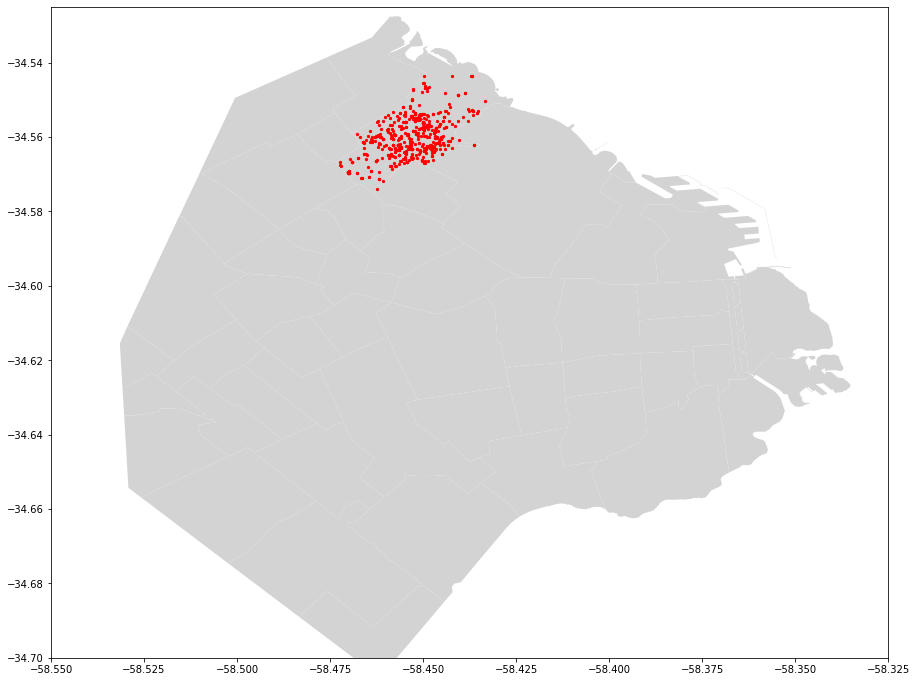

,search_longitude,search_latitude,timestamp,leave,arrive,search_method,uid,search_hour,arrive_hour,leave_hour,stay_time,arrive_weekday,geometry,reservas_barrio
23,-58.454943,-34.564354,2021-02-25 11:22:32,2021-02-25 12:20:09,2021-02-25 11:20:09,searchInThisArea,None,11.0,11,12,0 days 01:00:00,3,POINT (-58.45494 -34.56435),True
24,-58.451924,-34.559296,2020-09-17 05:13:03,2020-09-17 11:00:00,2020-09-17 10:45:00,update_time_home,unauthenticated,5.0,10,11,0 days 01:00:00,3,POINT (-58.45192 -34.55930),True
59,-58.459364,-34.564842,2021-02-20 21:54:12,2021-02-20 22:53:44,2021-02-20 21:53:44,searchInThisArea,i5Wh05mUiYTcQtvyUaQ2Xj7y9Al1,21.0,21,22,0 days 01:00:00,5,POINT (-58.45936 -34.56484),True
138,-58.449966,-34.556189,2020-10-19 14:38:44,2020-10-19 15:45:44,2020-10-19 14:45:44,startup,BLLbW2aUT4Xd5Kyu4lUX98MMget1,14.0,14,15,0 days 01:00:00,0,POINT (-58.44997 -34.55619),True
145,-58.457418,-34.567670,2021-03-10 05:48:53,2021-03-10 07:00:53,2021-03-10 06:00:53,startup,unauthenticated,5.0,6,7,0 days 01:00:00,2,POINT (-58.45742 -34.56767),True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20934,-58.464070,-34.569014,2021-02-27 13:11:31,2021-02-27 14:15:31,2021-02-27 13:15:31,startup,unauthenticated,13.0,13,14,0 days 01:00:00,5,POINT (-58.46407 -34.56901),True
20944,-58.456023,-34.562773,2021-03-25 09:16:37,2021-03-25 10:30:24,2021-03-25 09:30:24,google,unauthenticated,9.0,9,10,0 days 01:00:00,3,POINT (-58.45602 -34.56277),True
20948,-58.449675,-34.557740,2020-11-11 08:47:49,2020-11-11 10:00:17,2020-11-11 09:00:17,google,unauthenticated,8.0,9,10,0 days 01:00:00,2,POINT (-58.44967 -34.55774),True
20956,-58.449878,-34.557497,2021-02-13 14:28:17,2021-02-13 15:27:03,2021-02-13 14:27:03,searchInThisArea,e8itgepSU1YX6Q48HtrDpz76OXr1,14.0,14,15,0 days 01:00:00,5,POINT (-58.44988 -34.55750),True


In [8]:
belgrano = search_neighborhood(neighborhood = 'belgrano', coordinates=data)
belgrano

In [9]:
coordinates = data
neighborhood_list = ['chacarita',
"paternal",
'villa crespo',
'villa del parque',
'almagro',
'caballito',
'dique 3',
'villa santa rita',
'monte castro',
'villa real',
'flores',
'floresta',
'constitucion',
'belgrano',
'recoleta',
'retiro',
'san cristobal',
'boedo',
'velez sarsfield',
'villa luro',
'parque patricios',
'mataderos',
'villa lugano',
'escollera exterior',
'nuñez',
'boca',
'dique 2',
'san telmo',
'saavedra',
'coghlan',
'villa urquiza',
'colegiales',
'balvanera',
'dique 4',
'villa gral. mitre',
'dique 1',
'parque chas',
'agronomia',
'villa ortuzar',
'barracas',
'parque avellaneda',
'parque chacabuco',
'nueva pompeya',
'palermo',
'villa riachuelo',
'villa soldati',
'villa pueyrredon',
'villa devoto',
'liniers',
'versalles',
'puerto madero',
'monserrat',
'san nicolas'
    ]

list_upper = []

for i in neighborhood_list:
    neighbor = i.upper()
    list_upper.append(neighbor)    

gpd_dataframes_list = [] 

bsas_map = gpd.read_file('../gopa_data/barrios-ciudad')
bsas_map.BARRIO[6] = 'DIQUE 3'
bsas_map.BARRIO[24] = 'NUÑEZ'
bsas_map.BARRIO[26] = 'DIQUE 2'
bsas_map.BARRIO[33] = 'DIQUE 4'
bsas_map.BARRIO[35] = 'DIQUE 1' 

for neighbor in list_upper:
    gpd_data = gpd.GeoDataFrame(coordinates,
                     geometry = gpd.points_from_xy(coordinates.search_longitude, coordinates.search_latitude))

    polygon_neighbor = bsas_map[bsas_map['BARRIO'] == neighbor].geometry
    gpd_data ['neighbor'] = gpd_data.apply(lambda x: polygon_neighbor.contains(x.geometry), axis=1)
    gpd_data ['neighbor'] = gpd_data ['neighbor'].apply(lambda x: 0 if x == False else neighbor)
    gpd_data = gpd_data[gpd_data.neighbor != 0]
    gpd_dataframes_list.append(gpd_data)

all_data = pd.concat(gpd_dataframes_list)
    



<ipython-input-9-c7eb525d0cb9>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bsas_map.BARRIO[6] = 'DIQUE 3'
<ipython-input-9-c7eb525d0cb9>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bsas_map.BARRIO[24] = 'NUÑEZ'
<ipython-input-9-c7eb525d0cb9>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bsas_map.BARRIO[26] = 'DIQUE 2'
<ipython-input-9-c7eb525d0cb9>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [10]:
all_data

,search_longitude,search_latitude,timestamp,leave,arrive,search_method,uid,search_hour,arrive_hour,leave_hour,stay_time,arrive_weekday,geometry,neighbor
146,-58.446923,-34.583735,2021-01-21 10:23:25,2021-01-21 11:30:17,2021-01-21 10:30:17,google,REwY2MGhNFSmVq4smD6dgXBniu83,10.0,10,11,0 days 01:00:00,3,POINT (-58.44692 -34.58373),CHACARITA
214,-58.446829,-34.583628,2020-09-24 14:38:32,2020-09-24 15:45:32,2020-09-24 14:45:32,startup,BLLbW2aUT4Xd5Kyu4lUX98MMget1,14.0,14,15,0 days 01:00:00,3,POINT (-58.44683 -34.58363),CHACARITA
357,-58.441093,-34.587517,2021-03-06 03:40:51,2021-03-10 23:38:00,2021-03-10 10:38:00,searchInThisArea,IdVRqzjM1OQGXufqTmZIRv2CPhk1,3.0,10,23,0 days 13:00:00,2,POINT (-58.44109 -34.58752),CHACARITA
443,-58.446923,-34.583735,2021-02-08 12:18:25,2021-02-08 13:15:34,2021-02-08 12:15:34,google,RMnlCQYA06TyfsrGhw8Rscp6dTp1,12.0,12,13,0 days 01:00:00,0,POINT (-58.44692 -34.58373),CHACARITA
616,-58.448010,-34.584375,2021-03-29 00:28:46,2021-03-29 01:27:53,2021-03-29 00:27:53,google,None,0.0,0,1,0 days 01:00:00,0,POINT (-58.44801 -34.58438),CHACARITA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21093,-58.368752,-34.602119,2021-03-10 13:51:04,2021-03-10 14:50:34,2021-03-10 13:50:34,google,None,13.0,13,14,0 days 01:00:00,2,POINT (-58.36875 -34.60212),SAN NICOLAS
21106,-58.373486,-34.606694,2020-11-10 19:59:36,2020-11-11 08:30:00,2020-11-11 07:30:00,this_area,unauthenticated,19.0,7,8,0 days 01:00:00,2,POINT (-58.37349 -34.60669),SAN NICOLAS
21111,-58.392193,-34.601958,2020-11-06 08:02:38,2020-11-06 09:15:38,2020-11-06 08:15:38,startup,fPYSBYyQLYRcgIXJn9xAZ2eXf423,8.0,8,9,0 days 01:00:00,4,POINT (-58.39219 -34.60196),SAN NICOLAS
21114,-58.383575,-34.604396,2021-03-15 09:30:47,2021-03-15 18:29:00,2021-03-15 16:29:00,updateTimeHome,None,9.0,16,18,0 days 02:00:00,0,POINT (-58.38357 -34.60440),SAN NICOLAS


# Cantidad de reservas en los barrios

<AxesSubplot:xlabel='count', ylabel='neighbor'>

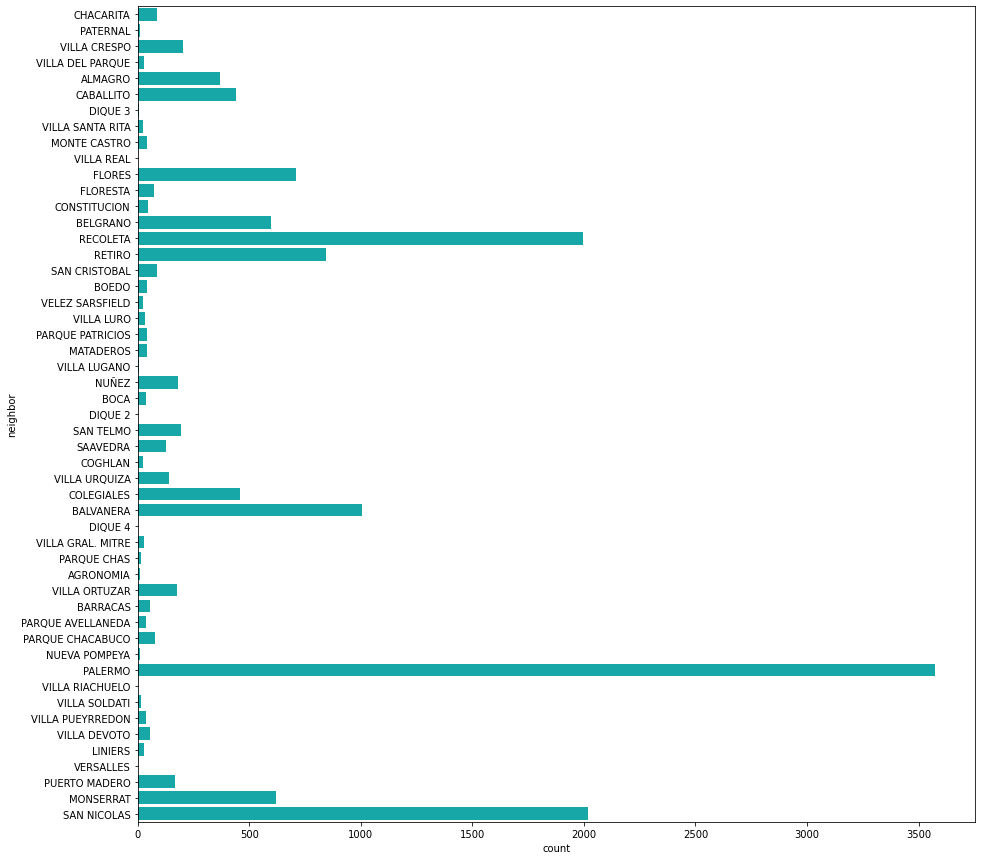

In [11]:
f, ax = plt.subplots(figsize=(15, 15))
sns.countplot(y="neighbor", data=all_data, color="c")


In [25]:
all_data.neighbor.value_counts()

PALERMO              3572
SAN NICOLAS          2019
RECOLETA             1996
BALVANERA            1007
RETIRO                846
FLORES                710
MONSERRAT             622
BELGRANO              600
COLEGIALES            459
CABALLITO             440
ALMAGRO               371
VILLA CRESPO          204
SAN TELMO             196
NUÑEZ                 182
VILLA ORTUZAR         175
PUERTO MADERO         167
VILLA URQUIZA         140
SAAVEDRA              127
CHACARITA              87
SAN CRISTOBAL          87
PARQUE CHACABUCO       79
FLORESTA               75
BARRACAS               54
VILLA DEVOTO           54
CONSTITUCION           48
BOEDO                  44
MONTE CASTRO           40
PARQUE PATRICIOS       40
MATADEROS              40
VILLA PUEYRREDON       38
BOCA                   36
PARQUE AVELLANEDA      36
VILLA LURO             35
VILLA GRAL. MITRE      30
VILLA DEL PARQUE       29
LINIERS                27
VELEZ SARSFIELD        26
VILLA SANTA RITA       26
COGHLAN     

In [98]:
all_data = all_data[all_data['uid'] != 'W2UoC9eld8MNS08rn8W2KVqKCYB2']
all_data = all_data[all_data['uid'] != 'REwY2MGhNFSmVq4smD6dgXBniu83']
all_data = all_data[all_data['uid'] != 'RMnlCQYA06TyfsrGhw8Rscp6dTp1']
all_data = all_data[all_data['uid'] != 'BLLbW2aUT4Xd5Kyu4lUX98MMget1']

In [160]:
all_data.insert(0, 'user_id', range(0, 0 + len(all_data)))

ValueError: cannot insert user_id, already exists

In [161]:
all_data.head(2)

,user_id,search_longitude,search_latitude,timestamp,leave,arrive,search_method,uid,search_hour,arrive_hour,leave_hour,stay_time,arrive_weekday,geometry,neighbor
357,0,-58.441093,-34.587517,2021-03-06 03:40:51,2021-03-10 23:38:00,2021-03-10 10:38:00,searchInThisArea,None,3.0,10,23,0 days 13:00:00,2,POINT (-58.44109 -34.58752),CHACARITA
616,1,-58.448010,-34.584375,2021-03-29 00:28:46,2021-03-29 01:27:53,2021-03-29 00:27:53,google,None,0.0,0,1,0 days 01:00:00,0,POINT (-58.44801 -34.58438),CHACARITA


# Los 10 barrios con más reservas

In [162]:
def getting_10_neighborhoods():
    list_10_neigh = all_data.neighbor.value_counts()[:10].index.tolist()
    all_data_10_list = []

    for neigh in list_10_neigh:
        all_data_10 = all_data[all_data['neighbor'] == neigh]
        all_data_10_list.append(all_data_10)

    all_data_10 = pd.concat(all_data_10_list)
    return all_data_10

all_data_10 = getting_10_neighborhoods()

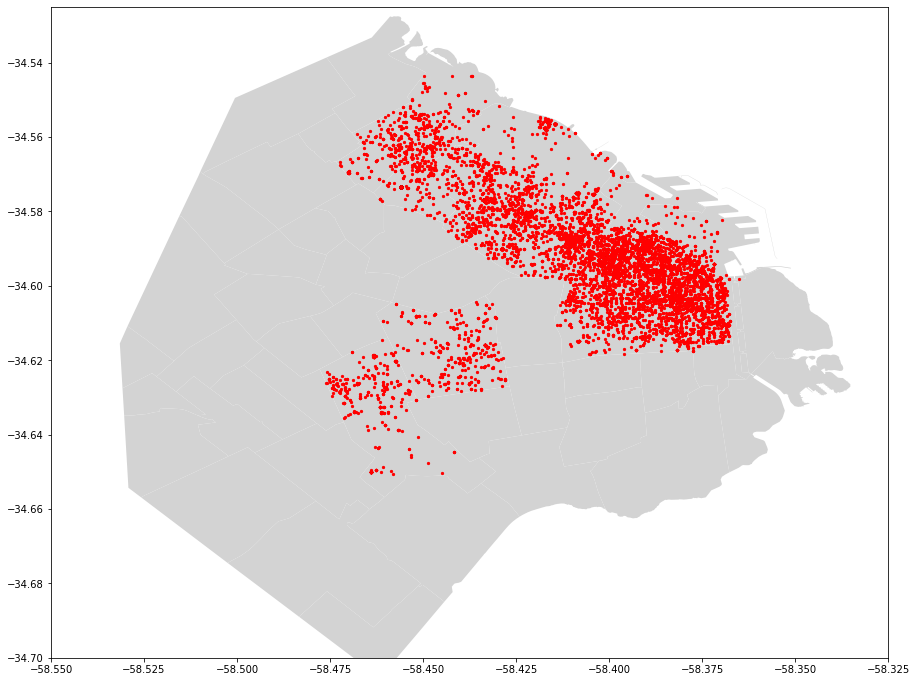

In [163]:
fig,ax = plt.subplots(figsize = (15,16))
bsas_map.plot(ax=ax, color='lightgrey')
all_data_10.plot(ax=ax, markersize=5, color='red')
ax.set_xlim([-58.550, -58.325])
ax.set_ylim([-34.700, -34.525])
plt.show()

# Horario más hot para las reservas en los 10 barrios

<AxesSubplot:xlabel='arrive_hour', ylabel='Count'>

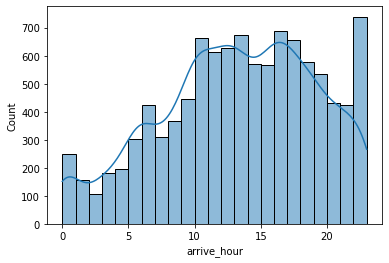

In [164]:
sns.histplot(data=all_data_10, x="arrive_hour", binwidth=1, kde=True)


# Horario más hot para las busquedas en los 10 barrios


<AxesSubplot:xlabel='search_hour', ylabel='Count'>

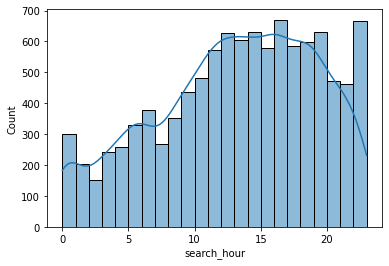

In [165]:
sns.histplot(data=all_data_10, x="search_hour", binwidth=1, kde=True)



# Día más hot de la semana para las reservas en los 10 barrios

In [191]:
weekday = pd.DataFrame(data=all_data_10.groupby("arrive_weekday").user_id.count()).reset_index()
weekday

,arrive_weekday,user_id
0,0,1722
1,1,1607
2,2,1712
3,3,1655
4,4,1635
5,5,1153
6,6,1022


(0.0, 2000.0)

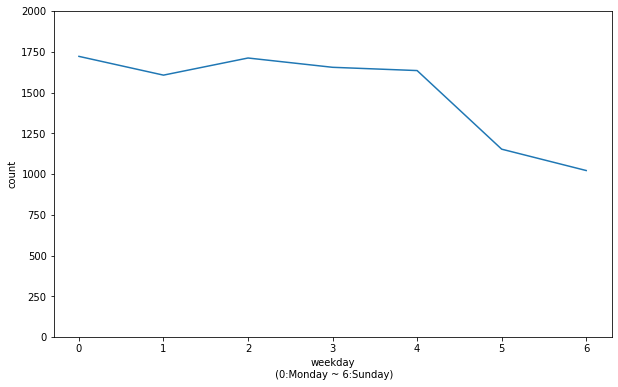

In [192]:
plt.figure(figsize=(10,6))

plt.plot(weekday['arrive_weekday'], weekday["user_id"])
plt.xlabel("weekday\n (0:Monday ~ 6:Sunday)")
plt.ylabel("count")
plt.ylim([0, 2000])

# Horarios más hot de la semana para las reservas en los 10 barrios


In [209]:
hour_time = pd.DataFrame(data=all_data_10.groupby("arrive_hour").user_id.count()).reset_index()
hour_time

,arrive_hour,user_id
0,0,251
1,1,157
2,2,108
3,3,183
4,4,195
5,5,303
6,6,423
7,7,309
8,8,366
9,9,445


(0.0, 800.0)

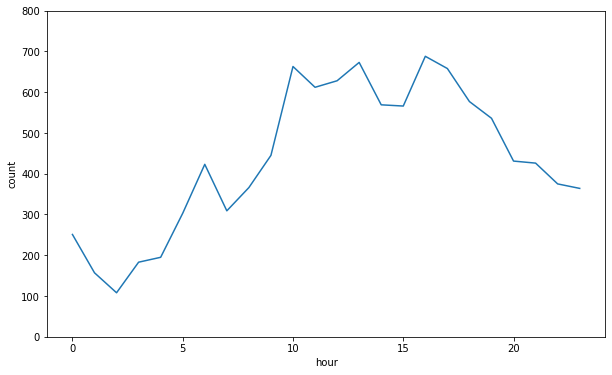

In [200]:
plt.figure(figsize=(10,6))

plt.plot(hour_time['arrive_hour'], hour_time["user_id"])
plt.xlabel("hour")
plt.ylabel("count")
plt.ylim([0, 800])

In [201]:
all_data_10.head(2)

,user_id,search_longitude,search_latitude,timestamp,leave,arrive,search_method,uid,search_hour,arrive_hour,leave_hour,stay_time,arrive_weekday,geometry,neighbor
1,7380,-58.419543,-34.575729,2021-02-04 15:56:36,2021-02-04 17:00:36,2021-02-04 16:00:36,startup,None,15.0,16,17,0 days 01:00:00,3,POINT (-58.41954 -34.57573),PALERMO
2,7381,-58.414274,-34.581036,2021-01-12 10:28:04,2021-01-12 11:30:04,2021-01-12 10:30:04,startup,None,10.0,10,11,0 days 01:00:00,1,POINT (-58.41427 -34.58104),PALERMO
